In [1]:
from growing_instability_lib import *

Using TensorFlow backend.


In [2]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = sorted(set(sample_sub.columns.difference(['id'])))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
target_columns = sorted(topics)
len(topics)

160

In [3]:
%%time
wvec_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'wvec_trainingX')
fvec_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'fvec_trainingX')
word2idx_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'word2idx_trainingX')
_word2idx = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', '_word2idx')
trainingY = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'trainingY')

CPU times: user 8.75 s, sys: 2.44 s, total: 11.2 s
Wall time: 13.2 s


In [4]:
%%time
word2ind = _word2idx.to_dict()

ind2word = {i: j + 1 for i, j in word2ind.items()}  # Remove the increment if data is fixed.
word2ind = {j: i for i, j in ind2word.items()}

ind2class = dict(enumerate(topics))
class2ind = {j: i for i, j in ind2class.items()}

num_samples = trainingY.shape[0]

training_X = word2idx_trainingX.head(num_samples)

training_Y = pd.DataFrame(zip(*np.where(trainingY.head(num_samples) == 1)), columns=['iloc', 'topics'])
training_WV = wvec_trainingX.head(num_samples)
training_FS = fvec_trainingX.head(num_samples)

training_Y = training_Y.groupby('iloc')['topics'].apply(list)
training_Y.index = trainingY.head(num_samples).index

# indices = sorted(training_Y.index.copy())
indices = sorted(training_Y.index[training_Y.index.str.contains('^201[0-9]')])
# np.random.shuffle(indices)
indices = pd.Index(indices)

training_X = training_X.ix[indices]
training_WV = training_WV.ix[indices]
training_FS = training_FS.ix[indices]
training_Y = training_Y.ix[indices]

dataset = zip(training_X, training_Y)

CPU times: user 20.3 s, sys: 48 ms, total: 20.3 s
Wall time: 20.2 s


In [5]:
# def generate_lstm_batch_dataset(dataset, word2ind, class2ind, max_len, batch_size=1000, shuffle=True):
#     if shuffle:
#         np.random.shuffle(dataset)

#     num_docs = len(dataset)
#     num_words = len(word2ind) + 1
#     num_class = len(class2ind)

#     for s in xrange(0, num_docs, batch_size):
#         x_batch = np.zeros([batch_size, max_len, num_words])
#         y_batch = np.zeros([batch_size, num_class])

#         for ix, (features, target) in enumerate(dataset[s:s + batch_size]):
#             # print features
#             for idx, feat in enumerate(features):
#                 if idx >= max_len:
#                     break

#                 # print feat, ind2word[feat]
#                 x_batch[ix, idx, feat] = 1

#             if not isinstance(target, list):
#                 target = [target]
                
#             for tg in target:
#                 y_batch[ix, tg] = 1

#         yield x_batch[:ix + 1, :, :], y_batch[:ix + 1, :]


# def infinite_lstm_dataset_generator(dataset, word2ind, class2ind, max_len, batch_size=100):
#     while 1:
#         for b in generate_lstm_batch_dataset(dataset, word2ind, class2ind, max_len, batch_size):
#             yield b

# # lens = []
# # for i in dataset:
# #     lens.append(len(i[0]))
# # pd.Series(lens).quantile(0.999)
# # Use the above to estimate the acceptable timeseries dimension.
# LSTM_TIMESERIES = 100
# id_lstm_gen = infinite_lstm_dataset_generator(dataset, word2ind, class2ind, max_len=LSTM_TIMESERIES, batch_size=10)



In [6]:
wv_sc = StandardScaler()
fs_sc = StandardScaler()

In [7]:
from keras.preprocessing import sequence


def build_target(y, size):
    e = np.zeros(size)
    e[y] = 1
    return e

def build_input_output_data(X, WV, FS, Y, maxlen):

    x = sequence.pad_sequences(X, maxlen=maxlen)
    y = np.vstack(Y.map(lambda x: build_target(x, len(topics))))
    wv = np.vstack(WV)
    fs = np.vstack(FS)
    
    return x, wv, fs, y


test_ix = training_Y.index.str.contains('^201[0-3]')
val_ix = training_Y.index.str.contains('^2014[ab]')


maxlen = 500


x_train, wv_train, fs_train, y_train = build_input_output_data(
    training_X.ix[test_ix],
    training_WV.ix[test_ix],
    training_FS.ix[test_ix],
    training_Y.ix[test_ix],
    maxlen=maxlen
)


x_val, wv_val, fs_val, y_val = build_input_output_data(
    training_X.ix[val_ix],
    training_WV.ix[val_ix],
    training_FS.ix[val_ix],
    training_Y.ix[val_ix],
    maxlen=maxlen
)

wv_train = wv_sc.fit_transform(wv_train)
fs_train = fs_sc.fit_transform(fs_train)

wv_val = wv_sc.transform(wv_val)
fs_val = fs_sc.transform(fs_val)

In [8]:
training_Y.shape, training_Y.ix[training_Y.index.str.contains('^2014[ab]')].shape

((94731,), (19387,))

In [9]:
# # Setup model
# model_lstm = keras.models.Sequential()
# model_lstm.add(keras.layers.Embedding(len(word2ind) + 1, 256))
# # model_lstm.add(keras.layers.LSTM(32, return_sequences=False, input_shape=(None, len(word2ind) + 1)))
# # model_lstm.add(keras.layers.Dropout(0.2))
# model_lstm.add(keras.layers.LSTM(16, return_sequences=False))
# model_lstm.add(keras.layers.Dense(128))
# model_lstm.add(keras.layers.Activation('relu'))
# model_lstm.add(keras.layers.Dropout(0.2))
# model_lstm.add(keras.layers.Dense(len(class2ind)))
# model_lstm.add(keras.layers.Activation('sigmoid'))
# model_lstm.compile(
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

# # for i in range(6):
# #     model_lstm.fit_generator(id_lstm_gen, steps_per_epoch=len(dataset), epochs=1)

In [12]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.models import Model

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=300, input_dim=len(word2ind) + 1, input_length=maxlen)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

auxiliary_output = Dense(len(class2ind), activation='sigmoid', name='aux_output')(lstm_out)


wv_input = Input(shape=(300,), name='wv_input')
fs_input = Input(shape=(300,), name='fs_input')

x = keras.layers.concatenate([lstm_out, wv_input, fs_input])

# We stack a deep densely-connected network on top
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# And finally we add the main logistic regression layer
main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(x)

model = Model(inputs=[main_input, wv_input, fs_input], outputs=[main_output, auxiliary_output])

In [13]:
import tensorflow as K


def f1_micro(y_true, y_pred):
    TP = K.metrics.true_positives(y_true, K.round(y_pred))
    FP = K.metrics.false_positives(y_true, K.round(y_pred))
    FN = K.metrics.false_negatives(y_true, K.round(y_pred))
    
    p = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FP))
    r = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FN))
    
    return (2.0 * p * r) / (p + r)

In [14]:
model.compile(optimizer='adam',
              loss={'main_output': 'categorical_crossentropy', 'aux_output': 'categorical_crossentropy'},
              loss_weights={'main_output': 1., 'aux_output': 0.2}, metrics=['accuracy', f1_micro])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 500, 300)      105478200                                    
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 32)            42624                                        
____________________________________________________________________________________________________
wv_input (InputLayer)            (None, 300)           0                                            
___________________________________________________________________________________________

In [15]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# model.fit(X, y, validation_split=0.2, callbacks=[early_stopping])

In [16]:
# import keras.backend as K
# K.clear_session()

In [17]:
# model.train_on_batch(
#     {'main_input': x_train[:10], 'wv_input': np.vstack(training_WV)[:10], 'fs_input': np.vstack(training_FS)[:10]},
#     {'main_output': y_train[:10], 'aux_output': y_train[:10]}
# )

In [23]:
%%time
# And trained it via:
batch_size = 600
model.fit(
    {'main_input': x_train, 'wv_input': wv_train, 'fs_input': fs_train},
    {'main_output': y_train, 'aux_output': y_train},
    epochs=1, batch_size=batch_size,   # 500
    validation_split=0.2,
    validation_data=(
        {'main_input': x_val, 'wv_input': wv_val, 'fs_input': fs_val},
        {'main_output': y_val, 'aux_output': y_val}
    )
)

Train on 75344 samples, validate on 19387 samples
Epoch 1/1
75344/75344 [==============================] - 90s - loss: 5.7852 - main_output_loss: 4.4710 - aux_output_loss: 6.5708 - main_output_acc: 0.3146 - main_output_f1_micro: 0.0806 - aux_output_acc: 0.0219 - aux_output_f1_micro: 0.0543 - val_loss: 5.2099 - val_main_output_loss: 3.8744 - val_aux_output_loss: 6.6773 - val_main_output_acc: 0.5009 - val_main_output_f1_micro: 0.1174 - val_aux_output_acc: 0.0247 - val_aux_output_f1_micro: 0.0627
CPU times: user 2min 37s, sys: 13.7 s, total: 2min 51s
Wall time: 1min 30s


In [25]:
%%time
model_name = 'models/lstm-word2vec-fasttext_2010-2013-data_categorical-crossentropy-2014-val-standard_scaled_wv_fs.model'
epochs = 5
for i in xrange(0, 100 // epochs):
    hist = model.fit(
        {'main_input': x_train, 'wv_input': wv_train, 'fs_input': fs_train},
        {'main_output': y_train, 'aux_output': y_train},
        epochs=epochs, batch_size=batch_size,   # 500
        validation_split=0.2,
        validation_data=(
            {'main_input': x_val, 'wv_input': wv_val, 'fs_input': fs_val},
            {'main_output': y_val, 'aux_output': y_val}
        )
    )

    model.save(model_name.format(i))
    print
    print('Done with epoch: {}'.format((i + 1) * epochs))
    with open('lstm-word2vec-fasttext.epoch.csv', 'a') as fl:
        fl.write(model_name + '\n')
        fl.write('Epoch {}\n'.format((i + 1) * epochs))
        fl.write('{}\n'.format(datetime.now()))
        fl.write('\n'.join(['{}: {}'.format(k, v[0]) for k, v in hist.history.items()]))
        fl.write('\n\n')
    print

Train on 75344 samples, validate on 19387 samples
Epoch 1/5
75344/75344 [==============================] - 90s - loss: 4.6000 - main_output_loss: 3.3217 - aux_output_loss: 6.3916 - main_output_acc: 0.5008 - main_output_f1_micro: 0.1473 - aux_output_acc: 0.0711 - aux_output_f1_micro: 0.0670 - val_loss: 4.9924 - val_main_output_loss: 3.6438 - val_aux_output_loss: 6.7431 - val_main_output_acc: 0.5482 - val_main_output_f1_micro: 0.1750 - val_aux_output_acc: 0.0781 - val_aux_output_f1_micro: 0.0705
Epoch 2/5
75344/75344 [==============================] - 91s - loss: 4.3330 - main_output_loss: 3.0616 - aux_output_loss: 6.3572 - main_output_acc: 0.5308 - main_output_f1_micro: 0.1987 - aux_output_acc: 0.0835 - aux_output_f1_micro: 0.0729 - val_loss: 4.9120 - val_main_output_loss: 3.5592 - val_aux_output_loss: 6.7639 - val_main_output_acc: 0.5620 - val_main_output_f1_micro: 0.2208 - val_aux_output_acc: 0.0778 - val_aux_output_f1_micro: 0.0751
Epoch 3/5
75344/75344 [=============================

75344/75344 [==============================] - 90s - loss: 2.9898 - main_output_loss: 2.1310 - aux_output_loss: 4.2941 - main_output_acc: 0.6539 - main_output_f1_micro: 0.4688 - aux_output_acc: 0.3793 - aux_output_f1_micro: 0.0995 - val_loss: 4.9381 - val_main_output_loss: 3.6945 - val_aux_output_loss: 6.2183 - val_main_output_acc: 0.5605 - val_main_output_f1_micro: 0.4722 - val_aux_output_acc: 0.1483 - val_aux_output_f1_micro: 0.0996
Epoch 4/5
75344/75344 [==============================] - 90s - loss: 2.9121 - main_output_loss: 2.0950 - aux_output_loss: 4.0857 - main_output_acc: 0.6603 - main_output_f1_micro: 0.4754 - aux_output_acc: 0.4132 - aux_output_f1_micro: 0.0997 - val_loss: 4.9576 - val_main_output_loss: 3.7256 - val_aux_output_loss: 6.1600 - val_main_output_acc: 0.5622 - val_main_output_f1_micro: 0.4787 - val_aux_output_acc: 0.1607 - val_aux_output_f1_micro: 0.0998
Epoch 5/5
75344/75344 [==============================] - 90s - loss: 2.8381 - main_output_loss: 2.0547 - aux_out

75344/75344 [==============================] - 90s - loss: 2.1450 - main_output_loss: 1.6685 - aux_output_loss: 2.3827 - main_output_acc: 0.7296 - main_output_f1_micro: 0.5523 - aux_output_acc: 0.6813 - aux_output_f1_micro: 0.1028 - val_loss: 5.6917 - val_main_output_loss: 4.4828 - val_aux_output_loss: 6.0446 - val_main_output_acc: 0.5152 - val_main_output_f1_micro: 0.5542 - val_aux_output_acc: 0.2682 - val_aux_output_f1_micro: 0.1029

Done with epoch: 35

Train on 75344 samples, validate on 19387 samples
Epoch 1/5
75344/75344 [==============================] - 90s - loss: 2.1167 - main_output_loss: 1.6514 - aux_output_loss: 2.3263 - main_output_acc: 0.7317 - main_output_f1_micro: 0.5561 - aux_output_acc: 0.6892 - aux_output_f1_micro: 0.1030 - val_loss: 5.7081 - val_main_output_loss: 4.4931 - val_aux_output_loss: 6.0755 - val_main_output_acc: 0.5176 - val_main_output_f1_micro: 0.5579 - val_aux_output_acc: 0.2702 - val_aux_output_f1_micro: 0.1030
Epoch 2/5
75344/75344 [=================

75344/75344 [==============================] - 89s - loss: 1.8040 - main_output_loss: 1.4552 - aux_output_loss: 1.7441 - main_output_acc: 0.7592 - main_output_f1_micro: 0.6083 - aux_output_acc: 0.7637 - aux_output_f1_micro: 0.1059 - val_loss: 6.4274 - val_main_output_loss: 5.1515 - val_aux_output_loss: 6.3794 - val_main_output_acc: 0.4899 - val_main_output_f1_micro: 0.6098 - val_aux_output_acc: 0.2861 - val_aux_output_f1_micro: 0.1060
Epoch 3/5
75344/75344 [==============================] - 89s - loss: 1.7953 - main_output_loss: 1.4509 - aux_output_loss: 1.7222 - main_output_acc: 0.7620 - main_output_f1_micro: 0.6111 - aux_output_acc: 0.7664 - aux_output_f1_micro: 0.1061 - val_loss: 6.5305 - val_main_output_loss: 5.2443 - val_aux_output_loss: 6.4311 - val_main_output_acc: 0.4846 - val_main_output_f1_micro: 0.6125 - val_aux_output_acc: 0.2868 - val_aux_output_f1_micro: 0.1063
Epoch 4/5
75344/75344 [==============================] - 89s - loss: 1.7815 - main_output_loss: 1.4419 - aux_out

75344/75344 [==============================] - 89s - loss: 1.6352 - main_output_loss: 1.3408 - aux_output_loss: 1.4722 - main_output_acc: 0.7719 - main_output_f1_micro: 0.6493 - aux_output_acc: 0.7844 - aux_output_f1_micro: 0.1116 - val_loss: 7.1936 - val_main_output_loss: 5.8464 - val_aux_output_loss: 6.7360 - val_main_output_acc: 0.4771 - val_main_output_f1_micro: 0.6504 - val_aux_output_acc: 0.2975 - val_aux_output_f1_micro: 0.1118
Epoch 5/5
75344/75344 [==============================] - 89s - loss: 1.6302 - main_output_loss: 1.3381 - aux_output_loss: 1.4601 - main_output_acc: 0.7720 - main_output_f1_micro: 0.6514 - aux_output_acc: 0.7851 - aux_output_f1_micro: 0.1120 - val_loss: 7.1479 - val_main_output_loss: 5.8037 - val_aux_output_loss: 6.7210 - val_main_output_acc: 0.4779 - val_main_output_f1_micro: 0.6524 - val_aux_output_acc: 0.2948 - val_aux_output_f1_micro: 0.1121

Done with epoch: 70

Train on 75344 samples, validate on 19387 samples
Epoch 1/5
75344/75344 [=================

75344/75344 [==============================] - 89s - loss: 1.5408 - main_output_loss: 1.2745 - aux_output_loss: 1.3317 - main_output_acc: 0.7768 - main_output_f1_micro: 0.6800 - aux_output_acc: 0.7907 - aux_output_f1_micro: 0.1188 - val_loss: 7.7118 - val_main_output_loss: 6.3145 - val_aux_output_loss: 6.9864 - val_main_output_acc: 0.4625 - val_main_output_f1_micro: 0.6807 - val_aux_output_acc: 0.3032 - val_aux_output_f1_micro: 0.1190
Epoch 2/5
75344/75344 [==============================] - 89s - loss: 1.5407 - main_output_loss: 1.2754 - aux_output_loss: 1.3268 - main_output_acc: 0.7780 - main_output_f1_micro: 0.6815 - aux_output_acc: 0.7919 - aux_output_f1_micro: 0.1192 - val_loss: 7.6968 - val_main_output_loss: 6.2877 - val_aux_output_loss: 7.0458 - val_main_output_acc: 0.4592 - val_main_output_f1_micro: 0.6823 - val_aux_output_acc: 0.3005 - val_aux_output_f1_micro: 0.1195
Epoch 3/5
75344/75344 [==============================] - 89s - loss: 1.5366 - main_output_loss: 1.2727 - aux_out

In [26]:
hist.history

{'aux_output_acc': [0.79290984432695777,
  0.79438308487654385,
  0.79438308231970844,
  0.79479452806892203,
  0.79429017601941743],
 'aux_output_f1_micro': [0.1234986738998575,
  0.12401480770007925,
  0.12451566183964496,
  0.12503920535460655,
  0.1255943038298917],
 'aux_output_loss': [1.2778704689297866,
  1.273654517372542,
  1.2695746469279969,
  1.2649296698714041,
  1.2627735187936979],
 'loss': [1.5057219573078857,
  1.4960603192369506,
  1.5006809289426555,
  1.5023055333928157,
  1.4959213040036541],
 'main_output_acc': [0.77933211667341751,
  0.77812432584602587,
  0.78100444626772725,
  0.77738106652641781,
  0.78125662523537187],
 'main_output_f1_micro': [0.69425208673884242,
  0.69557244688063624,
  0.69686611359679895,
  0.6981417263774361,
  0.69938933478467002],
 'main_output_loss': [1.2501478531882626,
  1.2413294074084253,
  1.2467659947016001,
  1.2493195939934869,
  1.2433665936275207],
 'val_aux_output_acc': [0.3003559006425997,
  0.29674523754622117,
  0.30458

In [27]:
# %%time
# for j in xrange(i, i + (100 // epochs)):
#     hist = model.fit(
#         {'main_input': x_train, 'wv_input': wv_train, 'fs_input': fs_train},
#         {'main_output': y_train, 'aux_output': y_train},
#         epochs=epochs, batch_size=batch_size,   # 500
#         validation_split=0.2,
#         validation_data=(
#             {'main_input': x_val, 'wv_input': wv_val, 'fs_input': fs_val},
#             {'main_output': y_val, 'aux_output': y_val}
#         )
#     )

#     model.save(model_name.format(i))
#     print
#     print('Done with epoch: {}'.format((j + 1) * epochs))
#     with open('lstm-word2vec-fasttext.epoch.csv', 'a') as fl:
#         fl.write(model_name + '\n')
#         fl.write('Epoch {}\n'.format((j + 1) * epochs))
#         fl.write('{}\n'.format(datetime.now()))
#         fl.write('\n'.join(['{}: {}'.format(k, v[0]) for k, v in hist.history.items()]))
#         fl.write('\n\n')
#     print

In [19]:
i = j

In [29]:
g = model.predict({'main_input': x_train[:100], 'wv_input': wv_train[:100], 'fs_input': fs_train[:100]})

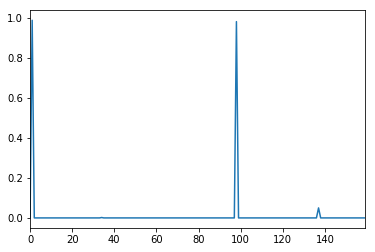

In [30]:
%matplotlib inline
ix = 29
pd.Series(g[0][ix]).plot()

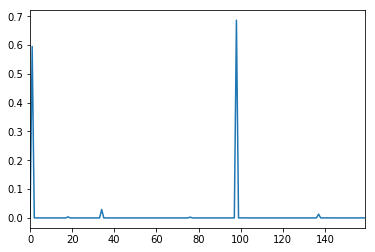

In [31]:
pd.Series(g[1][ix]).plot()

In [32]:
thresh = 0.5
np.where(y_train[ix] == 1), np.where(g[0][ix] > thresh), np.where(g[1][ix] > thresh)

((array([ 1, 98]),), (array([ 1, 98]),), (array([ 1, 98]),))

In [33]:
wvmodel = Word2Vec.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.w2v.model')

In [34]:
fsmodel = fasttext.load_model('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.fasttext.model.bin')

In [35]:
def transform_fasttext(tokens, stopwords=[]):
    global fsmodel
    # This requires fsmodel to be present in the namespace.
    fs_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords)]
    ).map(lambda x: np.array([fsmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return fs_feature_vec


def transform_unsupervised_sentiment_neuron(tokens, stopwords=[]):
    # This requires fsmodel to be present in the namespace.
    
    usn_feature_vec = usnmodel.transform(tokens)

    # usn_feature_vec = tokens.map(
    #     lambda x: [w for w in x.split() if (w not in stopwords)]
    # ).map(lambda x: np.array([usnmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return usn_feature_vec


def transform_word2vec(tokens, stopwords=[]):
    global wvmodel
    # This requires wvmodel to be present in the namespace.
    wv_feature_vec = tokens.map(
        lambda x: [w for w in x.split() if (w not in stopwords and w in wvmodel.wv.vocab)]
    ).map(lambda x: np.array([wvmodel[w] for w in x]).mean(axis=0) if len(x) > 0 else np.nan)

    return wv_feature_vec


def parallel_generate_word_vectors(samp, transformer, stopwords, batch, num_proc):
    with Parallel(n_jobs=num_proc) as parallel:
        dataset = []
        is_break = False
        i = 0

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(
                    delayed(transformer)(
                        t_df, stopwords
                    )
                )

            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return pd.concat(dataset)


In [36]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05, thresh = 0.5):
#     mx = pred.mean() + 3 * pred.std()
    return np.where(pred > thresh)[0]  

In [37]:
def word2idx_transform(word, _word2idx):
    return _word2idx.get(word, 0)


In [38]:
def extract_features_for(df, min_batch=2000, stopwords=[], num_proc=7):
    df_tokens = transform_text(df)
    
    batch = min(df_tokens.shape[0] / num_proc, min_batch)

    print('Computing fs features...')
    fvec = parallel_generate_word_vectors(df_tokens, transform_fasttext, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Computing wv features...')
    wvec = parallel_generate_word_vectors(df_tokens, transform_word2vec, stopwords=stopwords, batch=batch, num_proc=num_proc)

    print('Mapping word indices...')
    word_indices = df_tokens.map(lambda x: [word2idx_transform(i, _word2idx) for i in x.split()])
    
    return word_indices, wvec, fvec

In [39]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T
    del(data)

In [40]:
%%time
test_word_indices,test_wvec, test_fvec = extract_features_for(test_df)

Computing fs features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Computing wv features...
Current batch in main thread: 6498
Current batch in main thread: 14079
Mapping word indices...
CPU times: user 45.7 s, sys: 7.08 s, total: 52.8 s
Wall time: 2min 16s


In [41]:
assert(np.all(test_wvec[test_wvec.isnull()].index == test_fvec[test_fvec.isnull()].index))
test_null_index = test_wvec[test_wvec.isnull()].index.union(test_fvec[test_fvec.isnull()].index)

In [42]:
test_null_index

Index([u'TestData_02543', u'TestData_05012', u'TestData_05830'], dtype='object')

,bodyText,topics,webPublicationDate
TestData_00001,"On 5 April, a two-year-old accidentally squeez...",[],01-01-2015
TestData_00002,Looking back at 2014 from the perspective of a...,[],01-01-2015
TestData_00003,A 22-year-old man arrested by police investiga...,[],01-01-2015
TestData_00004,The place where nine-year-old Najia Warshaga l...,[],01-01-2015
TestData_00005,"The annual Beaujolais contest, the showcase fo...",[],01-01-2015
TestData_00006,It would be comforting to think 2015 will brin...,[],01-01-2015
TestData_00007,Just after 7pm on the evening of Saturday 28 M...,[],02-01-2015
TestData_00008,Police are hunting gunmen who fired at a crowd...,[],02-01-2015
TestData_00009,The US has imposed economic sanctions against ...,[],02-01-2015
TestData_00010,Sony Entertainment is unable to confirm that h...,[],02-01-2015


In [43]:
%%time
maxlen = 500

valid_test_index = test_word_indices.index.difference(test_null_index)
x_test = sequence.pad_sequences(test_word_indices.ix[valid_test_index], maxlen=maxlen)
wv_test = np.vstack(test_wvec.ix[valid_test_index])
fs_test = np.vstack(test_fvec.ix[valid_test_index])

wv_test = wv_sc.transform(wv_test)
fs_test = fs_sc.transform(fs_test)

CPU times: user 312 ms, sys: 8 ms, total: 320 ms
Wall time: 323 ms


In [45]:
test_probas = model.predict({'main_input': x_test, 'wv_input': wv_test, 'fs_input': fs_test}, batch_size=batch_size)

In [46]:
main_test_probas, aux_test_probas = test_probas

In [52]:
main_test_probas

array([[  2.78057731e-24,   7.19655091e-08,   5.58075374e-12, ...,
          4.79360933e-05,   3.82946334e-21,   7.24491334e-25],
       [  1.41906216e-27,   2.17561091e-11,   1.81838026e-15, ...,
          1.17292763e-17,   7.47898582e-21,   2.59653755e-28],
       [  4.57799233e-20,   7.50593529e-07,   1.46957273e-11, ...,
          1.28544229e-06,   2.85309862e-13,   1.26649546e-19],
       ..., 
       [  6.86277835e-09,   8.64830315e-02,   4.80795920e-01, ...,
          2.41652684e-04,   2.75913662e-05,   4.74667727e-09],
       [  5.49575189e-38,   4.44857619e-07,   2.41020888e-18, ...,
          3.25327984e-17,   3.73860250e-27,   0.00000000e+00],
       [  5.66381877e-34,   1.14101375e-07,   7.23591365e-09, ...,
          1.22702917e-18,   9.29351163e-23,   8.46117803e-34]], dtype=float32)

In [ ]:
test_df.ix[test_df.index.difference(test_null_index)]

In [47]:
skip_index = [int(s.split('_')[1]) - 1 for s in test_null_index]  # Subtract 1 since test index starts at 1 while enumerate starts at 0
skip_index

[2542, 5011, 5829]

In [48]:
main_test_probas.shape, test_df.shape

((7578, 160), (7581, 3))

In [101]:
%%time
# valid_test_feature_vec found below!
test_values = np.zeros([main_test_probas.shape[0], len(topics)])
for ix, pred in enumerate(main_test_probas):
    for v in get_classes(pred, thresh=0.5):
        test_values[ix][v] = 1

test_sub_df = pd.DataFrame(
    test_values,
    index=test_df.ix[test_df.index.difference(test_null_index)].index,
    columns=topics
)

null_test_df = pd.DataFrame(
    np.zeros((len(test_null_index), len(topics))),
    index=test_null_index,
    columns=topics
)

test_sub_df = test_sub_df.append(null_test_df)
test_sub_df = test_sub_df.sort_index()

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 31.5 ms


In [93]:
print '75344/75344 [==============================] - 89s - loss: 1.4959 - main_output_loss: 1.2434 - aux_output_loss: 1.2628 - main_output_acc: 0.7813 - main_output_f1_micro: 0.6994 - aux_output_acc: 0.7943 - aux_output_f1_micro: 0.1256 - val_loss: 8.0336 - val_main_output_loss: 6.5889 - val_aux_output_loss: 7.2234 - val_main_output_acc: 0.4520 - val_main_output_f1_micro: 0.7000 - val_aux_output_acc: 0.3014 - val_aux_output_f1_micro: 0.1259'

75344/75344 [==============================] - 89s - loss: 1.4959 - main_output_loss: 1.2434 - aux_output_loss: 1.2628 - main_output_acc: 0.7813 - main_output_f1_micro: 0.6994 - aux_output_acc: 0.7943 - aux_output_f1_micro: 0.1256 - val_loss: 8.0336 - val_main_output_loss: 6.5889 - val_aux_output_loss: 7.2234 - val_main_output_acc: 0.4520 - val_main_output_f1_micro: 0.7000 - val_aux_output_acc: 0.3014 - val_aux_output_f1_micro: 0.1259


In [102]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    'lstm_300-word2vec_300-fasttext_300-maxlen_500-dense_128_256_128-cat_cross-epoch_100-batch_size_500-val_main_output_f1_micro_0.7000-main_output_f1_micro_0.6994-main_output_loss_1.2434-data_2010_2013-val_data_2014-thresh_0.5-with_standard_scaler_wv_fs.csv', 
    index=False
)

In [74]:
test_sub_df.shape

(7581, 160)

In [111]:
# %%time
# adjust_index = 0
# # valid_test_feature_vec found below!
# test_values = np.zeros([test_df.shape[0], len(topics)])
# for ix, pred in enumerate(main_test_probas):
#     if ix in skip_index:
#         test_values[ix] = np.nan
#         # Increment adjust index so that we have the correct index for other samples
#         adjust_index += 1
#         continue

#     for v in get_classes(pred, thresh=0.05):
#         test_values[ix + adjust_index][v] = 1

# test_sub_df = pd.DataFrame(test_values, columns=sorted(topics), index=test_df.index)

# q = test_sub_df.sum(axis=1)
# assert(len(q[q.isnull()].index.difference(test_null_index)) == 0)

# test_sub_df = test_sub_df.fillna(0)

# # for i in test_feature_vec[test_feature_vec.isnull()].index:
# #     test_sub_df.ix[i] = np.zeros(len(topics))

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 32.6 ms


In [112]:
test_sub_df.ix[test_null_index].sum(axis=1)

TestData_02543    0.0
TestData_05012    0.0
TestData_05830    0.0
dtype: float64

In [75]:
test_sub_df.sum().sum()

9771.0

In [124]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    'lstm_300-word2vec_300-fasttext_300-maxlen_500-dense_64_64_64-cat_cross-epoch_210-batch_size_750-val_main_output_f1_micro_0.5760-main_output_f1_micro_0.5751-main_output_loss_0.9143-data_2010_2013-val_data_2014-thresh_0.05.csv', 
    index=False
)

In [86]:
e = test_sub_df['zikavirus']
e[e==1]

Series([], Name: zikavirus, dtype: float64)

In [87]:
top_submission = pd.read_csv('basic_nn_submission_0.649_accuracy_multi_class.csv')
top_submission.set_index('id').sum().sum()

14328

In [88]:
wrong_index_lstm_sub = pd.read_csv('lstm.2014b_training_700_maxlen_64cell_100epochs_0.0025_threshold.csv')
wrong_index_lstm_sub.set_index('id').sum().sum()

9280

In [89]:
some_sub = pd.read_csv('basic_nn_submission_full_training_data_0.9958_validation_accuracy_binary_crossentropy.csv')
some_sub.set_index('id').sum().sum()

34952

In [90]:
print top_submission.set_index('id')[top_submission.set_index('id').sum(axis=1) == 0].shape

print wrong_index_lstm_sub.set_index('id')[wrong_index_lstm_sub.set_index('id').sum(axis=1) == 0].shape

print some_sub.set_index('id')[some_sub.set_index('id').sum(axis=1) == 0].shape

print test_sub_df[test_sub_df.sum(axis=1) == 0].shape

(2197, 160)
(3957, 160)
(12, 160)
(1503, 160)


In [106]:
top_submission.set_index('id').ix[q[q == 0].index].sum(axis=1)

TestData_00011     0
TestData_00012     0
TestData_00015     0
TestData_00027     3
TestData_00029     0
TestData_00038     1
TestData_00042     5
TestData_00053     4
TestData_00056     1
TestData_00060     1
TestData_00066     0
TestData_00085     0
TestData_00087     1
TestData_00090     0
TestData_00092     0
TestData_00107     3
TestData_00111     0
TestData_00114     0
TestData_00115     1
TestData_00118     0
TestData_00119     0
TestData_00121     0
TestData_00123     0
TestData_00125     0
TestData_00127     0
TestData_00128     1
TestData_00139     1
TestData_00140     1
TestData_00144     0
TestData_00147     2
                  ..
TestData_07445     0
TestData_07456     3
TestData_07461     1
TestData_07462     4
TestData_07465     0
TestData_07468     0
TestData_07471     1
TestData_07475     0
TestData_07486    10
TestData_07495     1
TestData_07509     0
TestData_07514     3
TestData_07515     1
TestData_07523     0
TestData_07533     2
TestData_07534     2
TestData_0754

In [91]:
q = test_sub_df.sum(axis=1)
q[q==0].shape

(1222,)

In [92]:
q.describe()

count    7581.000000
mean        2.160929
std         1.739411
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
dtype: float64

In [157]:
q = trainingY.sum(axis=1)

In [158]:
q.describe()

count    236286.000000
mean          1.392787
std           0.762577
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
dtype: float64

In [82]:
test_df.sample(5)

,bodyText,topics,webPublicationDate
TestData_03241,A special British police unit was put on stand...,[],15-11-2015
TestData_04088,The youngest convict in a fatal gang-rape in N...,[],20-12-2015
TestData_06306,Former New York City mayor Rudy Giuliani has s...,[],28-07-2016
TestData_06083,"John Cantlie, the British journalist who has b...",[],13-07-2016
TestData_05896,Lawyers for the companies that manufactured an...,[],20-06-2016


In [83]:
test_ix = 'TestData_04088'

In [84]:
q = test_sub_df.ix[test_ix]
q[q>0]

humanrights    1.0
india          1.0
Name: TestData_04088, dtype: float64

In [91]:
q = top_submission.set_index('id').ix[test_ix]
q[q>0]

ukcrime    1
Name: TestData_04088, dtype: int64

In [92]:
q = some_sub.set_index('id').ix[test_ix]
q[q>0]

humanrights    1
india          1
protest        1
ukcrime        1
Name: TestData_04088, dtype: int64

In [62]:
q = wrong_index_lstm_sub.set_index('id').ix[test_ix]
q[q>0]

humanrights    1
Name: TestData_02924, dtype: int64

In [ ]:
Counter-terrorism policy
 
Foreign policy
 
Defence policy
 
Islamic State
 
Syria
 
news

In [83]:
s = trainingY.sum()
unseen_topics = s[s.isnull()].index

In [85]:
set(topics).intersection(unseen_topics)

{'activism',
 'bastilledaytruckattack',
 'berlinchristmasmarketattack',
 'brusselsattacks',
 'charliehebdoattack',
 'francetrainattack',
 'munichshooting',
 'orlandoterrorattack',
 'parisattacks',
 'peaceandreconciliation',
 'sanbernardinoshooting',
 'tunisiaattack2015',
 'turkeycoupattempt',
 'zikavirus'}

In [170]:
for i in topics:
    print i

activism
afghanistan
aid
algerianhostagecrisis
alqaida
alshabaab
antiwar
arabandmiddleeastprotests
armstrade
australianguncontrol
australiansecurityandcounterterrorism
bastilledaytruckattack
belgium
berlinchristmasmarketattack
bigdata
biometrics
bokoharam
bostonmarathonbombing
britisharmy
brusselsattacks
cameroon
carers
charliehebdoattack
chemicalweapons
clusterbombs
cobra
conflictanddevelopment
controversy
criminaljustice
cybercrime
cyberwar
darknet
dataprotection
debate
defence
deflation
drones
drugs
drugspolicy
drugstrade
earthquakes
ebola
economy
egypt
encryption
energy
espionage
ethics
europeanarrestwarrant
europeancourtofhumanrights
events
extradition
famine
farright
firefighters
forensicscience
france
francetrainattack
freedomofspeech
genevaconventions
germany
guncrime
hacking
hashtags
helicoptercrashes
humanitarianresponse
humanrights
humanrightsact
humantrafficking
immigration
india
indonesia
internallydisplacedpeople
internationalcourtofjustice
internationalcriminaljustice
in

In [263]:
cosine_similarity(wvmodel['zika'], np.vstack(test_wvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.3445929

In [259]:
cosine_similarity(fsmodel['zika'], np.vstack(test_fvec.dropna())).max()

/home/avsolatorio/ml-ai/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0.38107796869050226

In [251]:
test_df.ix[4488 + 1]

bodyText              The World Health Organisation has convened an ...
topics                                                               []
webPublicationDate                                           28-01-2016
Name: TestData_04490, dtype: object

In [257]:
test_df.ix[6727 + 2]

bodyText              The United Nations security council has called...
topics                                                               []
webPublicationDate                                           17-09-2016
Name: TestData_06730, dtype: object

In [253]:
test_df.ix[359]

bodyText              We are deeply concerned that the counter-terro...
topics                                                               []
webPublicationDate                                           02-02-2015
Name: TestData_00360, dtype: object

In [270]:
q = test_sub_df.iloc[4488 + 1]
q[q > 0]

drugstrade    1.0
Name: TestData_04490, dtype: float64